In [5]:
def gate_normal(a, x):
    return a**(3*(1/x**3)) * (1/a)**3

import torch
a = 0.1
x = torch.rand((10,1))
print(x)
print(gate_normal(a, x))

tensor([[0.4331],
        [0.4015],
        [0.3619],
        [0.5987],
        [0.8841],
        [0.5271],
        [0.9418],
        [0.9071],
        [0.5326],
        [0.6490]])
tensor([[1.1602e-34],
        [0.0000e+00],
        [0.0000e+00],
        [1.0518e-11],
        [4.5558e-02],
        [3.2354e-18],
        [2.5664e-01],
        [9.5576e-02],
        [1.4005e-17],
        [1.0571e-08]])


Files already downloaded and verified
Files already downloaded and verified


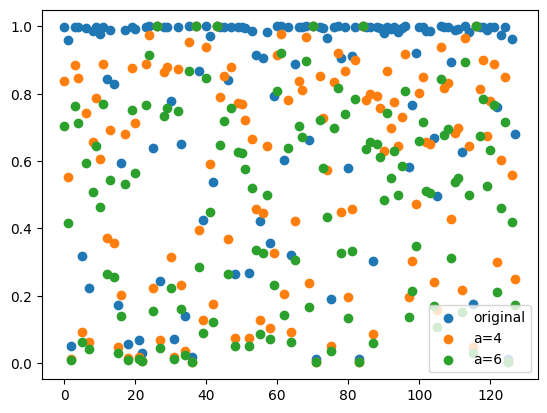

In [9]:
import cv2
from Dataloaders import dataloader_cifar10

_, _, val = dataloader_cifar10.Dataloader_cifar10_val()

from Models import mobilenetv2

model = mobilenetv2.MobileNetV2(num_classes=10)
model.load_state_dict(torch.load('./Weights/cifar-10/pretrained/mobilenetv2.pth'))
model.eval()
model.cuda()

import numpy as np

for ind, (img, label) in enumerate(val):
    img = img.cuda()
    label = label.cuda()
    output = model(img)
    output = torch.nn.functional.softmax(output, dim=1)
    conf = output.gather(1, label.view(-1,1))
   
    break

x = [x for x in range(128)]
y = conf.cpu().detach().numpy().flatten()
import matplotlib.pyplot as plt
plt.scatter(x, y, label='original')

# new_y = gate_normal(0.1, y)
# plt.scatter(x, new_y)

def gate_normal2(a, x):
    return (a*x)**3/(a**3)

new_y2 = gate_normal2(10, y)
# plt.scatter(x, new_y2)

def gate_normal3(a, x):
    return 1-(-x+1)**(1/a)

new_y3 = gate_normal3(4, y)
# torch_y = torch.tensor(y)
# new_y4 = 1-torch.pow(1-torch_y, 1/5)
plt.scatter(x, new_y3, label = 'a=4')

# new_y3 = gate_normal3(5, y)
# torch_y = torch.tensor(y)
# new_y4 = 1-torch.pow(1-torch_y, 1/5)
# plt.scatter(x, new_y3, label = 'a=5')

new_y4 = gate_normal3(6, y)
plt.scatter(x, new_y4, label = 'a=6')
plt.legend()
plt.show()

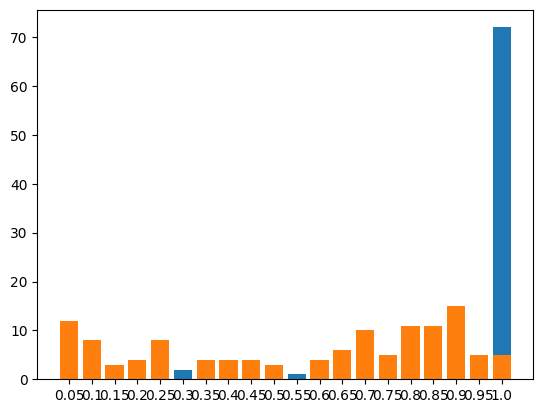

In [10]:
# show the number of 0.1 - 1.0
distribution = []
for i in range(1,21):
    distribution.append(len(np.where(y < i/20)[0]) - len(np.where(y < (i-1)/20)[0]))
plt.bar([str(i/20) for i in range(1, 21)], distribution)

# normalization
distribution = []
for i in range(1,21):
    distribution.append(len(np.where(new_y3 < i/20)[0]) - len(np.where(new_y3 < (i-1)/20)[0]))
plt.bar([str(i/20) for i in range(1, 21)], distribution)
plt.show()

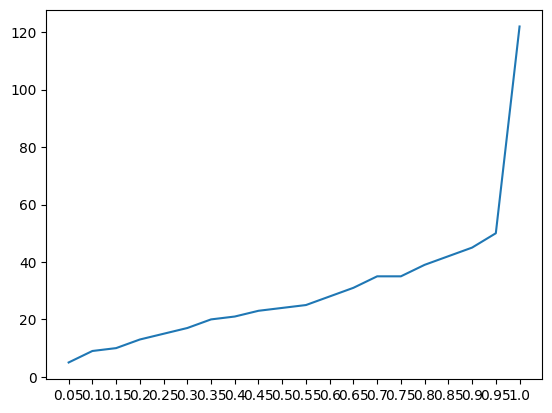

In [34]:
# plot the cdf 
cdf = []
for i in range(1,21):
    cdf.append(len(np.where(y < i/20)[0]))
plt.plot([str(i/20) for i in range(1, 21)], cdf)
plt.show()

[-0.89814396  1.          1.8536743   1.        ]


/tmp/ipykernel_3158352/2356305289.py:8: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, np.array([i/length for i in range(1, length+1)]), samples, p0=[1, 1, 1, 1])


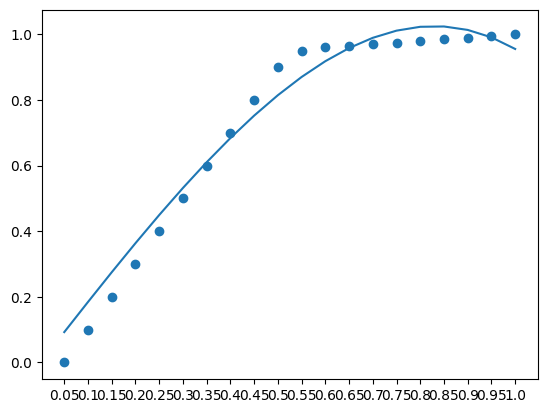

In [61]:
# curve fitting
from scipy.optimize import curve_fit
def func(x, a, b, c, d):
    return a*x**3 + c*x 

samples = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.96, 0.965, 0.97, 0.975, 0.98, 0.985, 0.99, 0.995, 1.0]
length = len(samples)
popt, pcov = curve_fit(func, np.array([i/length for i in range(1, length+1)]), samples, p0=[1, 1, 1, 1])
print(popt)
# plot samples
plt.scatter([str(i/length) for i in range(1, length+1)], samples)
plt.plot([str(i/length) for i in range(1, length+1)], func(np.array([i/length for i in range(1, length+1)]), *popt))
plt.show()


In [5]:
a = 0.95
from Utils import utils
import torch
b = utils.gate_normal3(6, torch.tensor([a]))
print(b)

c = utils.gate_renormal3(6, torch.tensor([b]))
print(c)

tensor([0.3930])
tensor([0.9500])


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 79/79 [02:21<00:00,  1.79s/it]


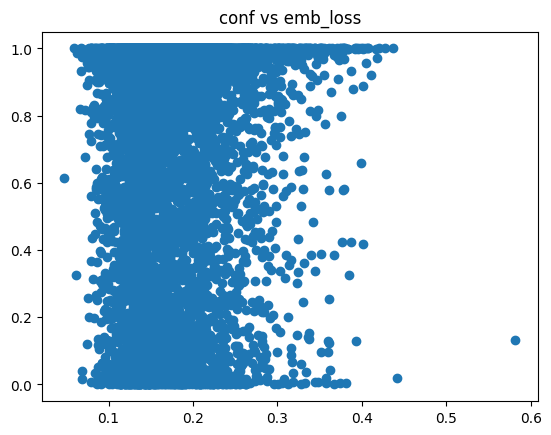

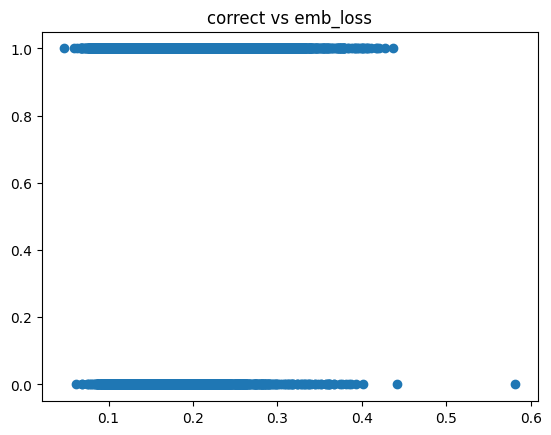

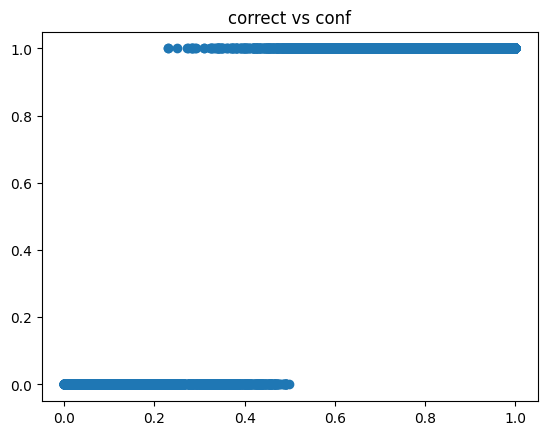

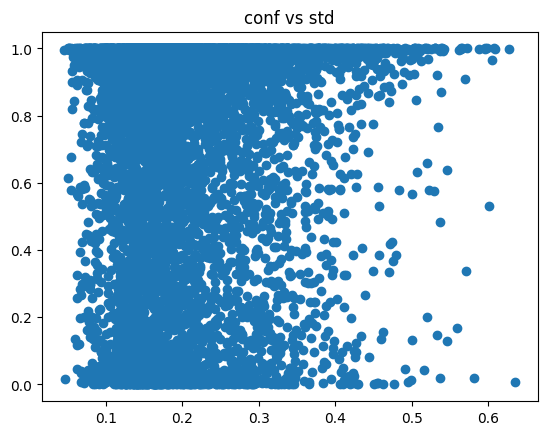

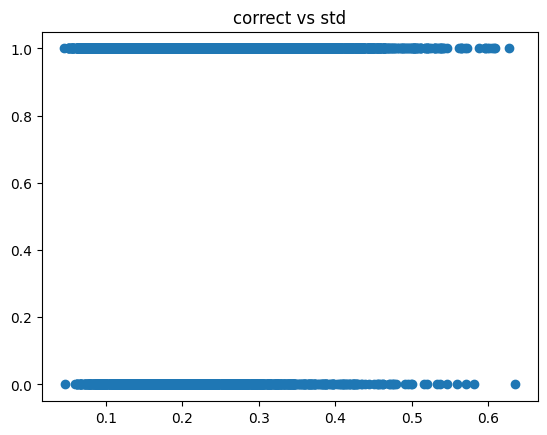

In [43]:
from Models import mobilenetv2
import torch
middle_size = 4
client, server = mobilenetv2.mobilenetv2_splitter(num_classes=10, weight_root='./Weights/cifar-10/')
middle = mobilenetv2.MobileNetV2_middle(middle=middle_size)

middle.load_state_dict(torch.load('./model_middle_%s.pth'%str(middle_size)))

client.eval()
middle.eval()
server.eval()
client.cuda()
middle.cuda()
server.cuda()

# loss = torch.nn.MSELoss()
def loss(x, y):
    ret = []
    # calculate the loss of each pixel
    for j in range(x.size(1)):
        for k in range(x.size(2)):
            ret.append(torch.nn.functional.mse_loss(x[:,j,k], y[:,j,k]).cpu().detach().numpy())
    return(ret)

import numpy as np

def get_mean_std(err):
    err = np.array(err)
    return np.mean(err), np.std(err)
from Dataloaders import dataloader_cifar10

_, _, val = dataloader_cifar10.Dataloader_cifar10_val()

emb_loss = []
conf_list = []
correct = []
mean_list =[]
std_list = []

from tqdm import tqdm
for ind, (img, label) in enumerate(tqdm(val)):
    img = img.cuda()
    label = label.cuda()
    
    out = client(img).detach()
    out2 = middle(out).detach()

    conf = server(out)
    conf = torch.nn.functional.softmax(conf, dim=1)

    result = torch.argmax(conf, dim=1)

    conf = conf.gather(1, label.view(-1,1))

    for i in range(img.size(0)):
        # emb_loss.append(loss(out2[i], out[i]).cpu().detach().numpy())
        err = loss(out2[i], out[i])
        mean, std = get_mean_std(err)
        emb_loss.append(mean)
        correct.append((result[i].item() == label[i]).cpu().detach().numpy())
        conf_list.append(conf[i].cpu().detach().numpy())
        std_list.append(std)

from matplotlib import pyplot as plt
plt.scatter(emb_loss, conf_list)
plt.title('conf vs emb_loss')
plt.show()
plt.scatter(emb_loss, correct)
plt.title('correct vs emb_loss')
plt.show()
plt.scatter(conf_list, correct)
plt.title('correct vs conf')
plt.show()
plt.scatter(std_list, conf_list)
plt.title('conf vs std')
plt.show()
plt.scatter(std_list, correct)
plt.title('correct vs std')
plt.show()

In [71]:
# print the output of the middle layer\
_, _, val = dataloader_cifar10.Dataloader_cifar10_val()
for ind, (img, label) in enumerate(tqdm(val)):
    img = img.cuda()
    label = label.cuda()
    
    out = client(img).detach()
    out2 = middle(out).detach()

    conf = server(out)
    conf = torch.nn.functional.softmax(conf, dim=1)

    result = torch.argmax(conf, dim=1)

    conf = conf.gather(1, label.view(-1,1))
    break

    


Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/79 [00:00<?, ?it/s]


In [61]:
import torch.nn as nn
m = nn.Sigmoid()
loss = nn.BCELoss()
input = torch.randn(3, 2, requires_grad=True)
target = torch.rand(3, 2, requires_grad=False)
output = loss(m(input), target)
output.backward()
print(m(input))
print(target)
print(output)


tensor([[0.7918, 0.3931],
        [0.4889, 0.1435],
        [0.1837, 0.3643]], grad_fn=<SigmoidBackward0>)
tensor([[0.0479, 0.8231],
        [0.1221, 0.4385],
        [0.6344, 0.6738]])
tensor(0.9924, grad_fn=<BinaryCrossEntropyBackward0>)


In [75]:
print(out[0,0,1])
print(out2[0,0,1])

s_out = server(out)
s_out = torch.nn.functional.softmax(s_out, dim=1)
s_out = torch.argmax(s_out, dim=1)

s_out2 = server(out2)
s_out2 = torch.nn.functional.softmax(s_out2, dim=1)
s_out2 = torch.argmax(s_out2, dim=1)
print(s_out[0])
print(s_out2[0])

tensor([1.5763, 1.3452, 1.3302, 1.2998, 1.2790, 1.2621, 1.2663, 1.3075, 1.3525,
        1.3955, 1.3919, 1.3624, 1.3397, 1.3505, 1.3775, 1.3722],
       device='cuda:0')
tensor([0.7749, 0.8233, 0.8651, 0.8664, 0.8669, 0.8679, 0.8595, 0.8756, 0.8840,
        0.8965, 0.8968, 0.8787, 0.8726, 0.8762, 0.9291, 1.2068],
       device='cuda:0')
tensor(2, device='cuda:0')
tensor(2, device='cuda:0')


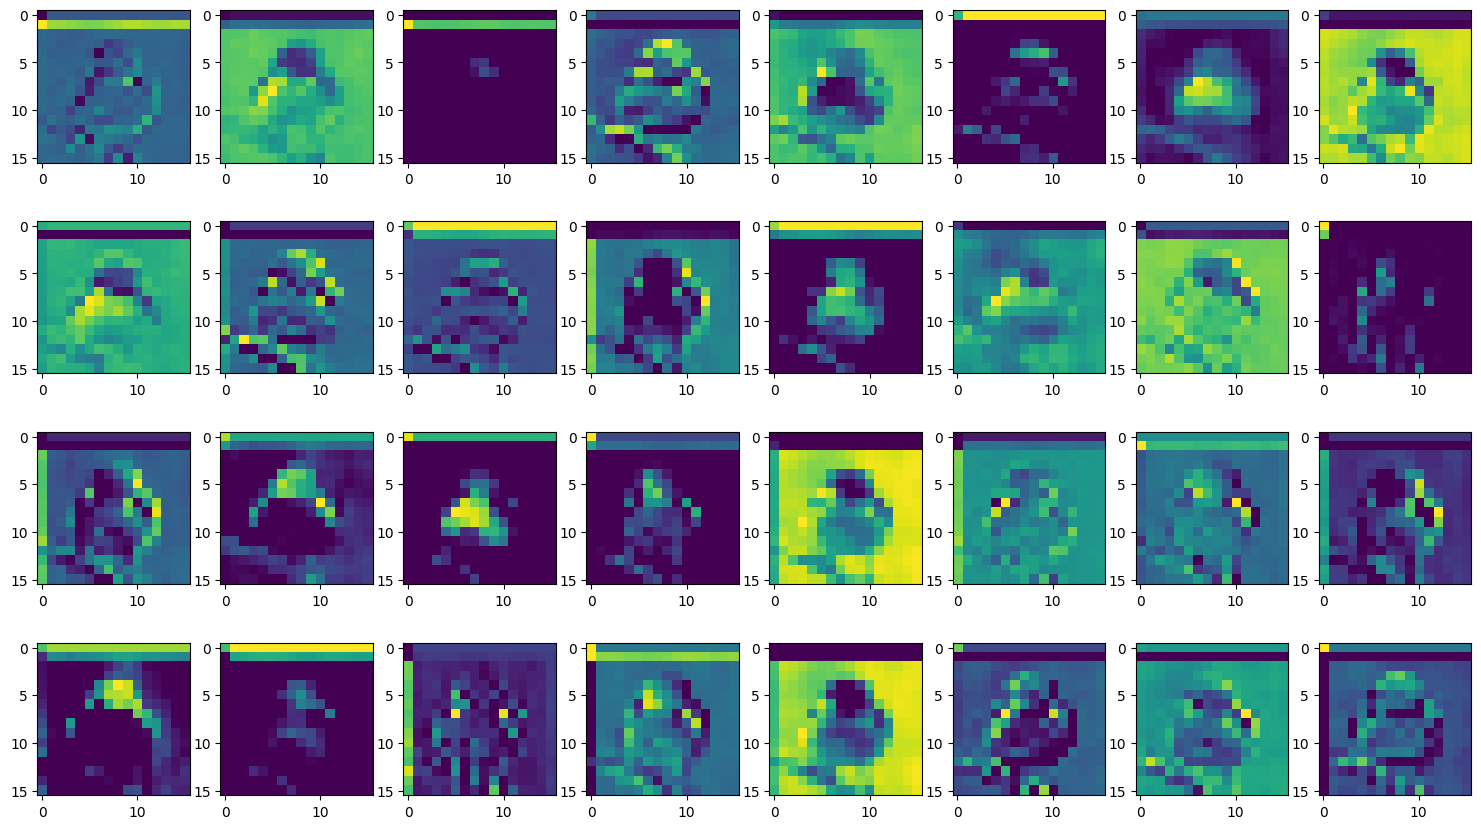

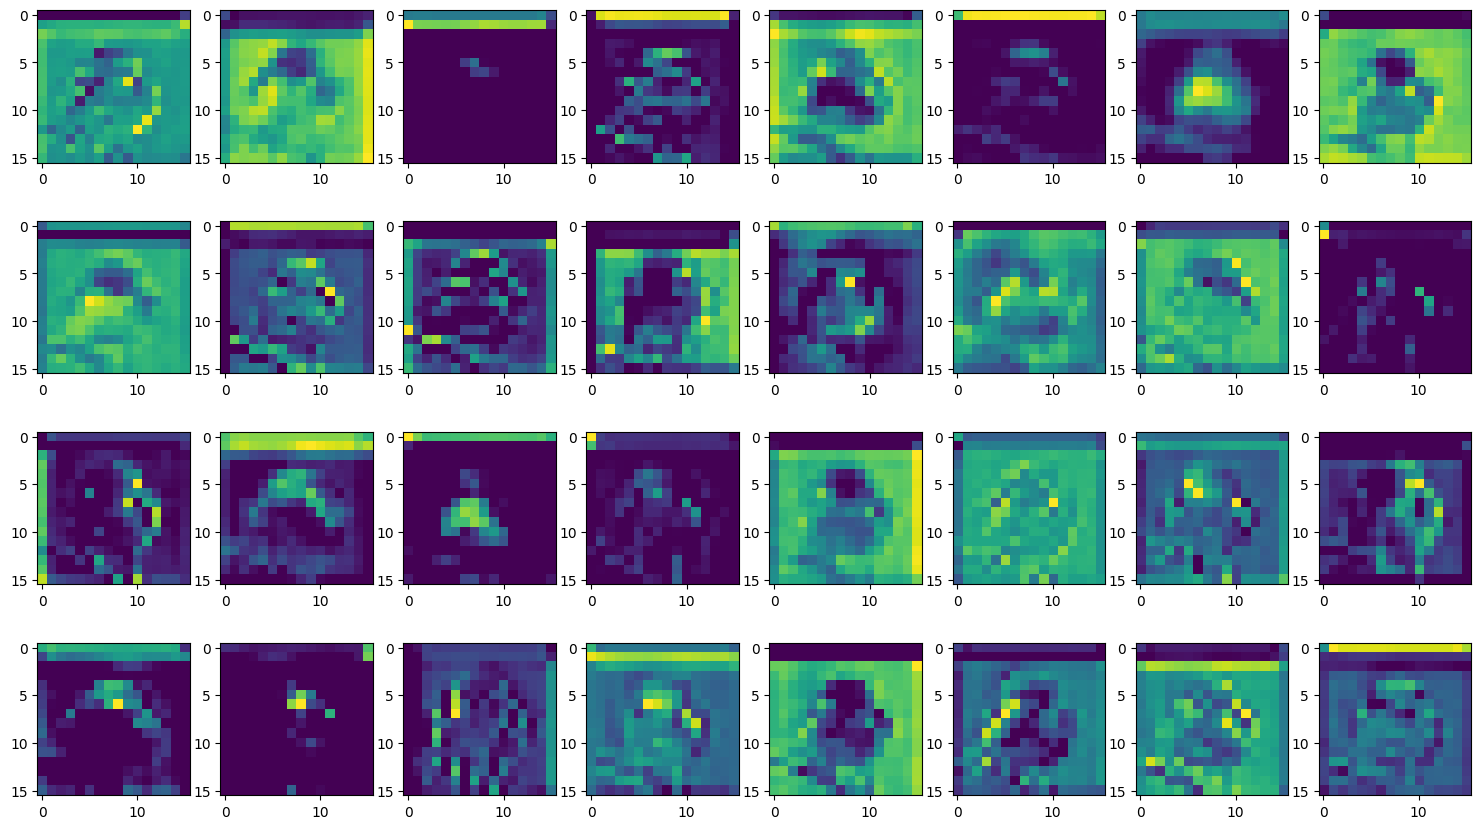

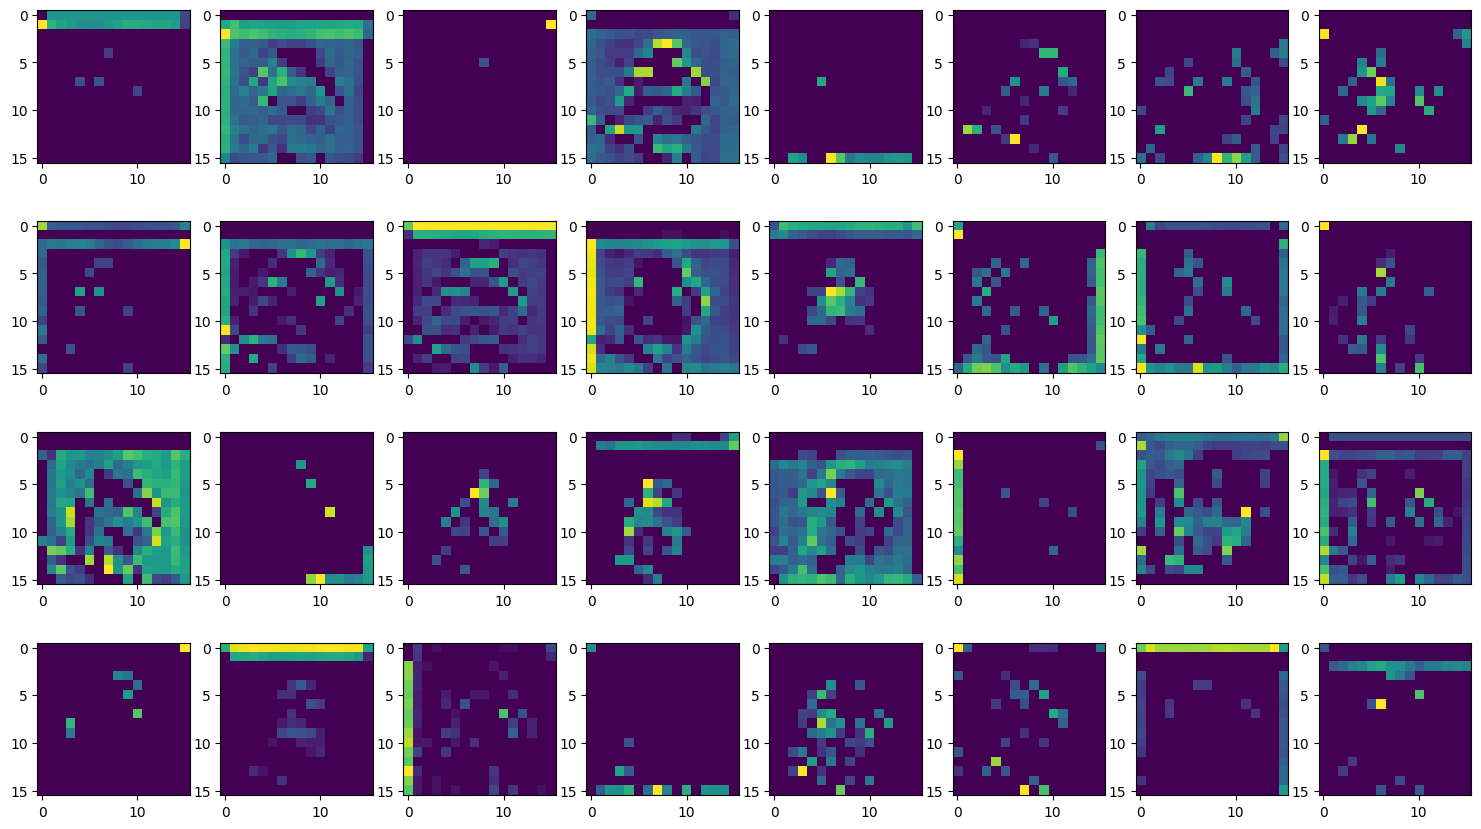

In [79]:
#plot the image of 32 images in out and out2
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(4, 8)
# change the window size
fig.set_size_inches(18.5, 10.5)
for i in range(32):
    img = out[0,i].cpu().detach().numpy()
    axs[i//8, i%8].imshow(img)
plt.show()

fig, axs = plt.subplots(4, 8)
# change the window size
fig.set_size_inches(18.5, 10.5)
for i in range(32):
    img = out2[0,i].cpu().detach().numpy()
    axs[i//8, i%8].imshow(img)
plt.show()

# plot the difference of the two images
fig, axs = plt.subplots(4, 8)
# change the window size
fig.set_size_inches(18.5, 10.5)
for i in range(32):
    img = out[0,i].cpu().detach().numpy() - out2[0,i].cpu().detach().numpy()
    # filter out if the value is less then 0.1
    img = np.where(img < 0.1, 0, img)
    axs[i//8, i%8].imshow(img)
plt.show()

In [110]:
# plot the acc vs gate with error bound
# plot the the number of picture that can use the corresponding gate to get the same prediction vs gate

_, _, val = dataloader_cifar10.Dataloader_cifar10_val()
client, server = mobilenetv2.mobilenetv2_splitter(num_classes=10, weight_root='./Weights/cifar-10/')
client.eval()
server.eval()
client.cuda()
server.cuda()

middles = [x for x in range (1, 9)]
import numpy as np
g = len(middles)
all_img = 0
for ind, (img, label) in enumerate(val):
    all_img += img.size(0)

result_gate_eq_model = np.zeros((all_img,g)) # b, g
result_gate_eq_label = np.zeros((all_img,g)) # b, g

gates = []
from Models import mobilenetv2
for i in range(1, 9):
    gate = mobilenetv2.MobileNetV2_middle(middle=i)
    gate.load_state_dict(torch.load('./model_middle_%s.pth'%str(i)))
    gate.eval()
    gate.cuda()
    gates.append(gate)


for i in range(8):
    count = 0
    for ind, (img, label) in enumerate(tqdm(val)):
        len_img = img.size(0)
        img = img.cuda()
        label = label.cuda()

        gate = gates[i]
        
        out = client(img).detach()
        out2 = gate(out).detach()

        conf = server(out)
        conf = torch.nn.functional.softmax(conf, dim=1)
        target = torch.argmax(conf, dim=1) # b, 1; original model

        conf2 = server(out2)
        conf2 = torch.nn.functional.softmax(conf2, dim=1)
        target2 = torch.argmax(conf2, dim=1) # b, 1; reduced model

        # res
        res = torch.where(target == target2, 1, 0)
        res2 = torch.where(target2 == label, 1, 0)
        res = res.cpu().detach().numpy()
        res2 = res2.cpu().detach().numpy()
        result_gate_eq_model[count: count+len_img, i] = res
        result_gate_eq_label[count: count+len_img, i] = res2
        count += len_img



Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 79/79 [00:01<00:00, 55.79it/s]


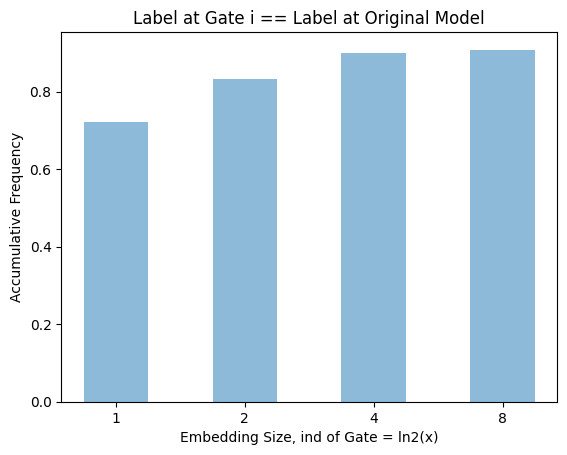

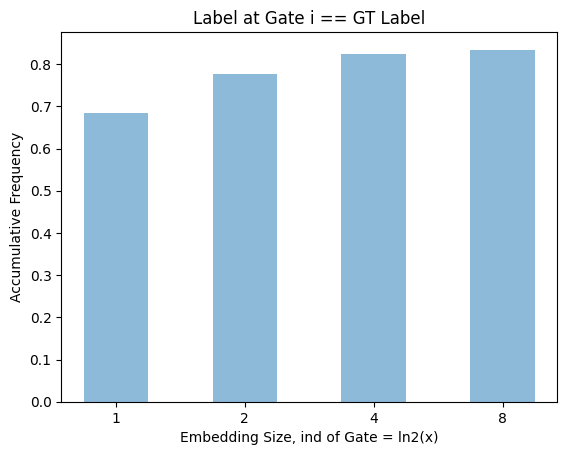

In [124]:
# the frequency of the same prediction
result_gate_eq_model_freq = np.sum(result_gate_eq_model, axis=0)/all_img
result_gate_eq_label_freq = np.sum(result_gate_eq_label, axis=0)/all_img

import matplotlib.pyplot as plt
# plot bar code
# plot 2**i vs the frequency
new_x = [2**i for i in range(0,4)]
plt.bar([str(x) for x in new_x], result_gate_eq_model_freq[[x-1 for x in new_x]], alpha=0.5, width=0.5)
plt.title('Label at Gate i == Label at Original Model')
plt.xlabel('Embedding Size, ind of Gate = ln2(x)')
plt.ylabel('Accumulative Frequency')
# bar is too thick
plt.show()

plt.bar([str(x) for x in new_x], result_gate_eq_label_freq[[x-1 for x in new_x]], alpha=0.5, width=0.5)
plt.title('Label at Gate i == GT Label')
plt.xlabel('Embedding Size, ind of Gate = ln2(x)')
plt.ylabel('Accumulative Frequency')
plt.show()

In [144]:
# the frequency of the same prediction
# plot the acc vs gate with error bound
# plot the the number of picture that can use the corresponding gate to get the same prediction vs gate

_, _, val = dataloader_cifar10.Dataloader_cifar10_val()
from Models import resnet
client, server = resnet.resnet_splitter(num_classes=10, weight_root='./Weights/cifar-10/', layers=50)
client.eval()
server.eval()
client.cuda()
server.cuda()

middles = [x for x in range (1, 8)]
import numpy as np
g = len(middles)
all_img = 0
for ind, (img, label) in enumerate(val):
    all_img += img.size(0)

result_gate_eq_model = np.zeros((all_img,g)) # b, g
result_gate_eq_label = np.zeros((all_img,g)) # b, g

gates = []
from Models import mobilenetv2
for i in range(7):
    gate = resnet.resnet_middle(middle=2**i)
    gate.load_state_dict(torch.load('./resnet_cifar-10_middle_%s.pth'%str(2**i)))
    gate.eval()
    gate.cuda()
    gates.append(gate)


for i in range(7):
    count = 0
    for ind, (img, label) in enumerate(tqdm(val)):
        len_img = img.size(0)
        img = img.cuda()
        label = label.cuda()

        gate = gates[i]
        
        out = client(img)
        out2 = gate.in_layer(out)

        # change it to 256 int
        # normalize
        out_max = torch.max(out2)
        out_min = torch.min(out2)
        out2 = (out2 - out_min)/(out_max - out_min) * 255
        out2 = out2.int()
        out2 = out2.float()
        out2 = out2 / 255 * (out_max - out_min) + out_min
        out2 = out2.cuda()
        out2 = gate.out_layer(out2)

        conf = server(out)
        conf = torch.nn.functional.softmax(conf, dim=1)
        target = torch.argmax(conf, dim=1) # b, 1; original model

        conf2 = server(out2)
        conf2 = torch.nn.functional.softmax(conf2, dim=1)
        target2 = torch.argmax(conf2, dim=1) # b, 1; reduced model

        # res
        res = torch.where(target == target2, 1, 0)
        res2 = torch.where(target2 == label, 1, 0)
        res = res.cpu().detach().numpy()
        res2 = res2.cpu().detach().numpy()
        result_gate_eq_model[count: count+len_img, i] = res
        result_gate_eq_label[count: count+len_img, i] = res2
        count += len_img

result_gate_eq_model_freq = np.sum(result_gate_eq_model, axis=0)/all_img
result_gate_eq_label_freq = np.sum(result_gate_eq_label, axis=0)/all_img

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 79/79 [00:01<00:00, 59.81it/s]


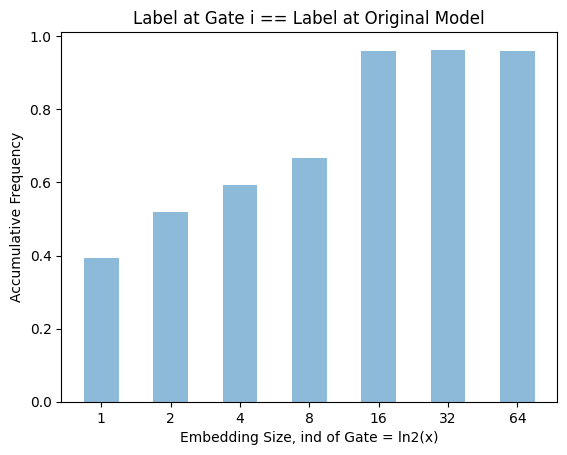

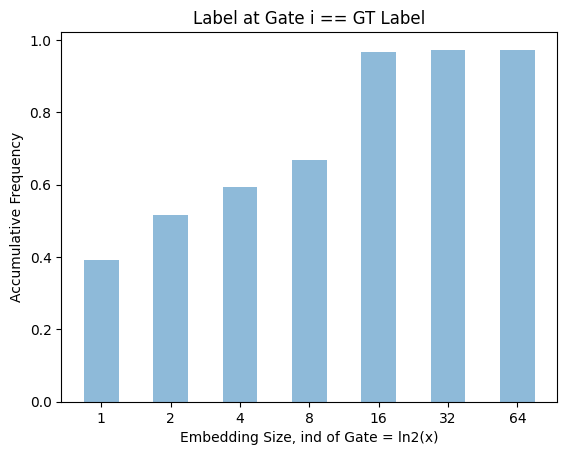

: 

In [145]:
import matplotlib.pyplot as plt
# plot bar code
x = [x for x in range(7)]
plt.bar(x, result_gate_eq_model_freq, alpha=0.5, width=0.5)
plt.title('Label at Gate i == Label at Original Model')
plt.xlabel('Embedding Size, ind of Gate = ln2(x)')
plt.ylabel('Accumulative Frequency')
plt.xticks(x, [str(2**i) for i in range(7)])
# bar is too thick
plt.show()

plt.bar(x, result_gate_eq_label_freq, alpha=0.5, width=0.5)
plt.title('Label at Gate i == GT Label')
plt.xlabel('Embedding Size, ind of Gate = ln2(x)')
plt.ylabel('Accumulative Frequency')
plt.xticks(x, [str(2**i) for i in range(7)])
plt.show()

In [8]:
# plot the acc vs gate with error bound
# plot the the number of picture that can use the corresponding gate to get the same prediction vs gate
from Dataloaders import dataloader_image_20
from Models import mobilenetv2
_, test, _, _ = dataloader_image_20.Dataloader_imagenet_20_integrated()
client, server = mobilenetv2.mobilenetv2_splitter(num_classes=1000, weight_root='./Weights/imagenet/')
client.eval()
server.eval()
client.cuda()
server.cuda()

middles = [x for x in range (5)]
import numpy as np
g = len(middles)
# all_img = 0
# for ind, (img, label, _) in enumerate(test):
#     all_img += img.size(0)
# print(all_img)
all_img = 5087

result_gate_eq_model = np.zeros((all_img,g)) # b, g
result_gate_eq_label = np.zeros((all_img,g)) # b, g

gates = []
import torch
from Models import mobilenetv2
for i in range(5):
    gate = mobilenetv2.MobileNetV2_middle(middle=2**i)
    gate.load_state_dict(torch.load('./mobile_imagenet_middle_%s.pth'%str(2**i)))
    gate.eval()
    gate.cuda()
    gates.append(gate)

from tqdm import tqdm
for i in range(5):
    count = 0
    for ind, (img, label, _) in enumerate(tqdm(test)):
        len_img = img.size(0)
        img = img.cuda()
        label = label.cuda()

        gate = gates[i]
        
        out = client(img).detach()
        out2 = gate(out).detach()

        conf = server(out)
        conf = torch.nn.functional.softmax(conf, dim=1)
        target = torch.argmax(conf, dim=1) # b, 1; original model

        conf2 = server(out2)
        conf2 = torch.nn.functional.softmax(conf2, dim=1)
        target2 = torch.argmax(conf2, dim=1) # b, 1; reduced model

        # res
        res = torch.where(target == target2, 1, 0)
        res2 = torch.where(target2 == label, 1, 0)
        res = res.cpu().detach().numpy()
        res2 = res2.cpu().detach().numpy()
        result_gate_eq_model[count: count+len_img, i] = res
        result_gate_eq_label[count: count+len_img, i] = res2
        count += len_img



100%|██████████| 51/51 [00:18<00:00,  2.71it/s]


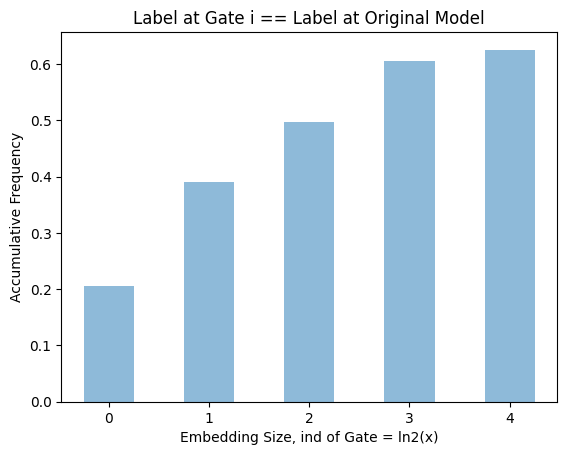

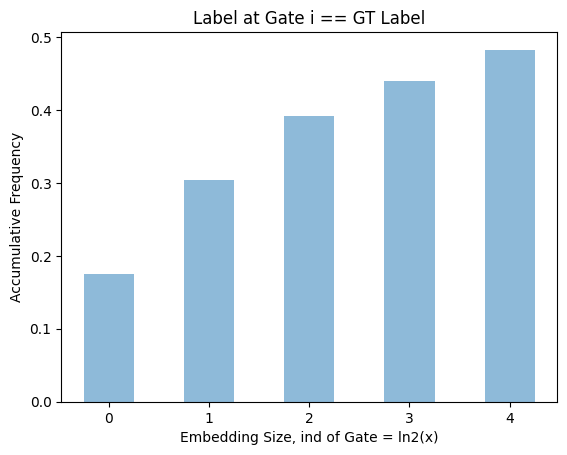

: 

In [13]:
# the frequency of the same prediction
result_gate_eq_model_freq = np.sum(result_gate_eq_model, axis=0)/all_img
result_gate_eq_label_freq = np.sum(result_gate_eq_label, axis=0)/all_img

import matplotlib.pyplot as plt
# plot bar code
# plot 2**i vs the frequency
new_x = [i for i in range(5)]
plt.bar([str(x) for x in new_x], result_gate_eq_model_freq[[x for x in new_x]], alpha=0.5, width=0.5)
plt.title('Label at Gate i == Label at Original Model')
plt.xlabel('Embedding Size, ind of Gate = ln2(x)')
plt.ylabel('Accumulative Frequency')
# bar is too thick
plt.show()

plt.bar([str(x) for x in new_x], result_gate_eq_label_freq[[x for x in new_x]], alpha=0.5, width=0.5)
plt.title('Label at Gate i == GT Label')
plt.xlabel('Embedding Size, ind of Gate = ln2(x)')
plt.ylabel('Accumulative Frequency')
plt.show()